
# Intorduction to Classification

## 1) Linear Discrimnant Analysis learns the weights of a linear boundary line between classes assumed to be of equal disributions, and can be seperated linearly

## 2) Quadratic Discrimnant Analysis learns the weights of a quadratic boundary equation between classes that are not linearly separable.

## 3) The perceptron learns the weight of classes that are not assumed to have similar distributions.

## 4) Linear SVM maximizes the distance between the decision boundary and the support vectors of the classes

## 5) Polynomial Kernel SVM

## 6) Radial Basis Function Kernel SVM

## 7) Multilayer Perceptron

## based on https://scikit-learn.org/stable/auto_examples/classification/plot_lda_qda.html#sphx-glr-auto-examples-classification-plot-lda-qda-py but extended to include datasets with classes from different distributions, polynomially seperable datasets, radially seperable datasets, with suitable classifiers such as Perceptrons, SVM with different Kernels, and MLP 

## Other classifier comparisons in: https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py 



## This example plots the covariance ellipsoids of each class and decision boundary learned by LDA and QDA, and compares the performance with 5 different datasets and 7 different classifiers. The ellipsoids display the double standard deviation for each class. With LDA, the standard deviation is the same for all the classes, while each class has its own standard deviation with QDA.

## First, import all required packages.

In [1]:
%matplotlib inline

from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors

from sklearn import datasets

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score

### Then, create the colour maps that you will need in the plots below. Colours in most programming languages are expressed in terms of their Red, Green, and Blue components. 

### Notice the following syntax:
### The colors.LinearSegmentedColormap function creates Colormap objects based on lookup tables using linear segments. This requires passing on input arguments as name of the Colourmap, the segmentdata expressed as a dictionary 

## Some Python syntax rules:

### Python Dictipnaries data structures are Key value pairs expressed in curly braces, key names as strings in quotations, and values based on the types. Each pair is followed by a comma to start another pair, or the ending curly brace.

### Python lists data structures are comma seperated list enclosed in square brackets. Every item can be another list, or string enclosed in quotations or any data type.

### Python tuples are ordered container of comma seperated elements enclosed in round brackets such that every position encode something specific. In this example, it is 3 values tuple, such that the first value is the red component, followed by the green component, then the blue component from 0 to 1 each.

### You can read more details about the expected dictionary format by using the "?" next to the function name as follows. This also work with any function you need to know more details about its input arguments, their default values, output, and what algorithm it performs.

In [2]:
# Colormap
cmap = colors.LinearSegmentedColormap(
    "red_blue_classes",
    {
        "red": [(0, 1, 1), (1, 0.7, 0.7)],
        "green": [(0, 0.7, 0.7), (1, 0.7, 0.7)],
        "blue": [(0, 0.7, 0.7), (1, 1, 1)],
    },
)
plt.cm.register_cmap(cmap=cmap)


### As explained in the lecture, LDA work well with datasets with classes from similar distriubutions, such as the Gaussian Distribution in which samples are symtrically spread around the mean equally. Each class is identified using its means, variance and covariance. 

### The following generate two datasets, each of 2 classes. The first with fixed covariance matrix, and the second with different covariance matrix. Again check the syntax and the function used, and use introspection such as "?" and "??" to read the documentation. check what "np.random.seed", "np.random.randn", "np.r_", "np.dot", "np.hstack" mean. Read the inline comments starting the "#" and highlighted in green to understand the code and the logic.

In [3]:
# Generate datasets
def dataset_fixed_cov():
    """Generate 2 Gaussians samples with the same covariance matrix"""
    n, dim = 300, 2
    np.random.seed(0)
    # Choose a covariance matrix
    C = np.array([[0.0, -0.23], [0.83, 0.23]])
    # stack rows of a random variable multiplied by the covariance matrix as members of the first class.
    # the following rows are random variables multiplied by the same covariance matrix but added to it [1, 1] to be shifted on both the x and y axis as members of the second class
    X = np.r_[
        np.dot(np.random.randn(n, dim), C),
        np.dot(np.random.randn(n, dim), C) + np.array([1, 1]),
    ]
    # the first half of the dataset are initialised with zero in the y indicating membership of class 1
    # the second half of the dataset are initialised with ones in the y indicating membership of class 2
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y


def dataset_cov():
    """Generate 2 Gaussians samples with different covariance matrices"""
    n, dim = 300, 2
    np.random.seed(0)
    C = np.array([[0.0, -1.0], [2.5, 0.7]]) * 2.0
    # here the second class uses the transpose covariance matrix and shift the sample differently on the x and y axis.
    X = np.r_[
        np.dot(np.random.randn(n, dim), C),
        np.dot(np.random.randn(n, dim), C.T) + np.array([1, 4]),
    ]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y

def dataset_different_distributions (draw=False):
    """Generate 2 classes from different disributions"""
    from scipy.stats import norm, gamma
    import seaborn as sns
    n, dim = 300, 2
        
    # generate random numbers from N(0,1)
    if draw:
        data_normal = norm.rvs(size=(n, dim),loc=0,scale=1)
        ax_normal = sns.displot(data_normal,
                  bins=100,
                  kde=True,
                  color='skyblue')
        ax_normal.set(xlabel='Normal Distribution', ylabel='Frequency')

        data_gamma = gamma.rvs(a=5, size=(n, dim))
        ax_gamma = sns.displot(data_gamma,
                  kde=True,
                  bins=100,
                  color='skyblue')
        ax_gamma.set(xlabel='Gamma Distribution', ylabel='Frequency')
   
    np.random.seed(0)
    C = np.array([[0.0, -1.0], [2.5, 0.7]]) * 2.0
    X = np.r_[
        norm.rvs(size=(n, dim),loc=0,scale=1), # First class are randomly generated from normal distributions with mean μ = 0 and standard deviation σ = 1.
        gamma.rvs(a=5, size=(n, dim)), # Second class come from the gamma distribution, which is described using two-parameters as: a shape parameter α=k, which is initialised here to 5 and an inverse scale parameter β=1/θ, called a rate parameter, which is left to defailt value = 1.
    ]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y

def dataset_polynomial(degree = 2, draw=False):
    n, dim = 300, 2
    
    # the following option can be generalised to higher dimension random dataset generation
    # n records, dim features, number of classes = 2
    # weights for each class (proportions of samples assigned to each class)
    #
    #X, y = datasets.make_classification(n_samples=n, n_features=dim, n_classes=2, n_redundant=0,
    #                                n_clusters_per_class=1, weights=[0.5, 0.3, 0.2], random_state=42)
    
    
    X, y = datasets.make_moons(n_samples=n, noise=0.2, random_state=0) # could be attempted for degree 2 polynomial
    if draw:
        # Create the plot
        fig, ax = plt.subplots(figsize=(9, 6))
        plt.xlabel("X0", fontsize=20)
        plt.ylabel("X1", fontsize=20)
        plt.scatter(X[:,0], X[:,1], s=50, c=y)
    return X, y

def dataset_radial(draw=False):
    """Generate non-linearly seperable classes"""
    n, dim = 300, 2
    X, y = datasets.make_circles(n_samples=n, noise=0.2, factor=0.5, random_state=42)
    
    if draw:
        fig, ax = plt.subplots(figsize=(6, 6))
        plt.xlabel("X0", fontsize=20)
        plt.ylabel("X1", fontsize=20)
        plt.scatter(X[:,0], X[:,1], s=60, c=y)

    return X, y


(array([[-6.04231633e-02,  5.05856960e-01],
        [ 6.19925946e-01, -4.75883080e-01],
        [ 2.16965376e-01,  3.49329904e-02],
        [ 7.37173361e-01,  5.63560553e-01],
        [-4.63792172e-01, -1.91887687e-01],
        [-5.24387893e-01,  1.27130337e-01],
        [-2.64778470e-01,  6.24050954e-01],
        [ 6.30312051e-02, -1.05770068e+00],
        [ 7.92938277e-01,  1.05318627e-01],
        [ 3.92021848e-01,  4.51508476e-01],
        [-3.12138352e-01,  1.11710657e-01],
        [-6.82777883e-01,  5.22759728e-01],
        [-2.67175047e-01,  1.54788070e-01],
        [-1.34527563e-01,  1.16429623e+00],
        [-7.76261842e-02,  7.63190372e-01],
        [-3.11973627e-01, -3.73965011e-02],
        [ 5.08745704e-01, -1.70876091e-01],
        [-4.11674257e-01,  4.51078572e-01],
        [ 1.28396412e+00, -8.22165688e-02],
        [ 6.70684763e-01,  4.91533148e-01],
        [-9.45655470e-01, -9.00970492e-02],
        [-2.09570654e-01, -1.29993436e+00],
        [-2.34908838e-01, -5.933

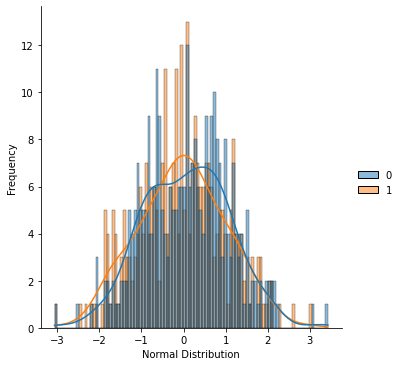

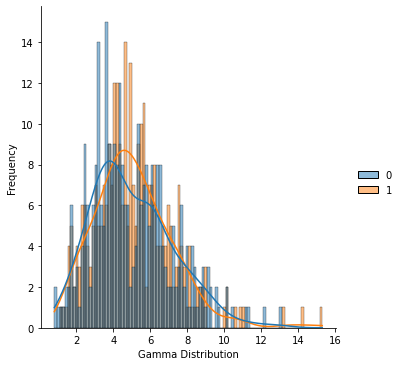

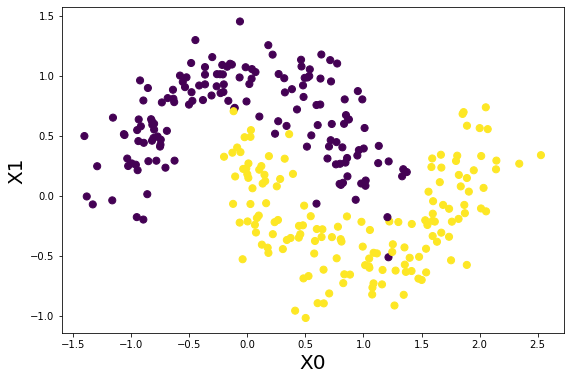

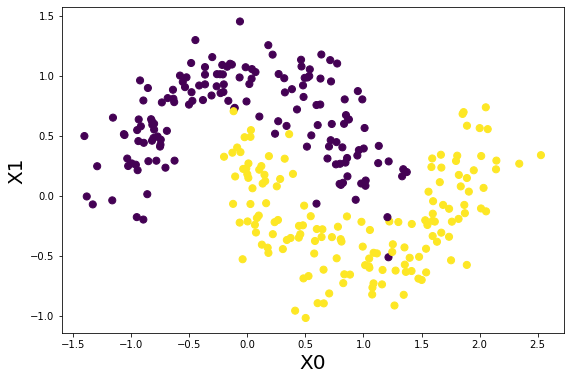

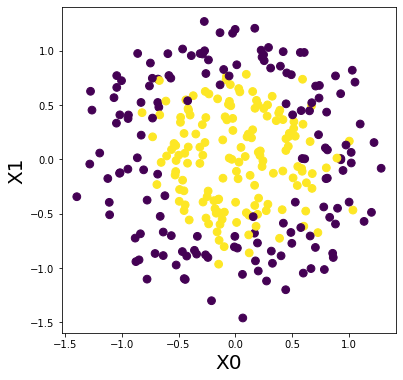

In [4]:
dataset_different_distributions(True)
dataset_polynomial(degree = 2,draw=True)
dataset_polynomial(degree = 3,draw=True)
dataset_radial(True)


### the following function creates a subplot in a grid of 5 rows and 7 columns to draw 35 subplots (5 x 7cells each containing a subplot). The iterator over the 35 subplots is in fig_index variable.

### The returned variable splot contain the plt details with title, y label, the data in the X variable, and the classes in the Y variable. The y_pred are the values predicted from multiplying the calculated weights with the X values, and compared with the ground truth to calculate the true positives.

In [5]:
# Plot functions
def plot_data(lda, X, y, y_pred, fig_index, perceptron = False):
    splot = plt.subplot(5, 7, fig_index)
    if fig_index == 1:
        plt.title("LDA")
        plt.ylabel("Data with\n fixed covariance")
    elif fig_index == 2:
        plt.title("QDA")
    elif fig_index == 3:
        plt.title("Perceptron")
    elif fig_index == 4:
        plt.title("Linear SVM")
    elif fig_index == 5:
        plt.title("Polynomial SVM")
    elif fig_index == 6:
        plt.title("Radial SVM")
    elif fig_index == 7:
        plt.title("MLP")
    elif fig_index == 8:
        plt.ylabel("Data with\n varying covariances")
    elif fig_index == 15:
        plt.ylabel("Data with different disributions")
    elif fig_index == 22:
        plt.ylabel("Polynomially seperable Dataset ")
    elif fig_index == 29:
        plt.ylabel("Radially seperable Dataset")


    tp = y == y_pred  # True Positive
    tp0, tp1 = tp[y == 0], tp[y == 1]  # true positives for each class.
    X0, X1 = X[y == 0], X[y == 1]      # seperating X values for class 1 in X0 and for Class 2 in X1
    X0_tp, X0_fp = X0[tp0], X0[~tp0]   # identifying the x values that are true positives _tp, and those that are false positives _fp for class 1
    X1_tp, X1_fp = X1[tp1], X1[~tp1]   # same as above for class 2

    # class 0: dots
    plt.scatter(X0_tp[:, 0], X0_tp[:, 1], marker=".", color="red") # draw true positives as red and following line dark red for false postives
    plt.scatter(X0_fp[:, 0], X0_fp[:, 1], marker="x", s=20, color="#990000")  # dark red

    # class 1: dots
    plt.scatter(X1_tp[:, 0], X1_tp[:, 1], marker=".", color="blue") # same for the second class but in blue for tp, and dark blue for false positives
    plt.scatter(
        X1_fp[:, 0], X1_fp[:, 1], marker="x", s=20, color="#000099"
    )  # dark blue

    # class 0 and 1 : contour areas
    nx, ny = 200, 100    # number of points to create on the x axis and the y-axis
    x_min, x_max = plt.xlim()  # range of values for x -axis and the following line for the y-axis
    y_min, y_max = plt.ylim()
    
    # meshgrid create 2 dimensional space, each dimension call the np.linspace that creates the required points linearly spaced from the minimum to the maximum value
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
    
    # use the trained model in LDA to predict the probability of each sample point created above in Z variable 
    if not perceptron:
        Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])       
        Z = Z[:, 1].reshape(xx.shape)
    else:
        Z = lda.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
    
    # Create a pseudocolor plot with a non-regular rectangular grid with xx and yy specifying the corners of the quadrilaterals,
    # using the cmap created earlier to colour the predicted classes in Z, colours are normalised from 0 to 1
    # using ? reveals that more arguments are passed to "matplotlib.collections.QuadMesh" such as zorder: https://matplotlib.org/stable/gallery/misc/zorder_demo.html 
    plt.pcolormesh(
        xx, yy, Z, cmap="red_blue_classes", norm=colors.Normalize(0.0, 1.0), zorder=0
    )
    plt.contour(xx, yy, Z, [0.5], linewidths=2.0, colors="white")

    if not perceptron:
        # colour the means of both classes as yellow asterisks * of size 15
        plt.plot(
            lda.means_[0][0],
            lda.means_[0][1],
            "*",
            color="yellow",
            markersize=15,
            markeredgecolor="grey",
        )
        plt.plot(
            lda.means_[1][0],
            lda.means_[1][1],
            "*",
            color="yellow",
            markersize=15,
            markeredgecolor="grey",
        )
    plt.annotate("Accuracy: " + str(accuracy_score(y_pred, y)), (x_min,y_max-(10*y_max/ny)))
    return splot

### Using the splot variable returned from the previous function for a given plot, the ellipse borders are drawn in the following function:

In [6]:
def plot_ellipse(splot, mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(
        mean,
        2 * v[0] ** 0.5,
        2 * v[1] ** 0.5,
        180 + angle,
        facecolor=color,
        edgecolor="black",
        linewidth=2,
    )
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.2)
    splot.add_artist(ell)
    splot.set_xticks(())
    splot.set_yticks(())

### The following functions calls the previous function for the 4 subplots for the 2 datasets, using LDA, then using QDA

In [7]:
def plot_lda_cov(lda, splot):
    plot_ellipse(splot, lda.means_[0], lda.covariance_, "red")
    plot_ellipse(splot, lda.means_[1], lda.covariance_, "blue")

In [8]:
def plot_qda_cov(qda, splot):
    plot_ellipse(splot, qda.means_[0], qda.covariance_[0], "red")
    plot_ellipse(splot, qda.means_[1], qda.covariance_[1], "blue")

## This is the main python code that calls the previous declared functions 

C:\Users\DELLPR~1\AppData\Local\Temp/ipykernel_22160/1932152443.py:65: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(
C:\Users\DELLPR~1\AppData\Local\Temp/ipykernel_22160/1932152443.py:65: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(
C:\Users\DELLPR~1\AppData\Local\Temp/ipykernel_22160/1932152443.py:65: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either spec

C:\Users\DELLPR~1\AppData\Local\Temp/ipykernel_22160/1932152443.py:65: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(
C:\Users\DELLPR~1\AppData\Local\Temp/ipykernel_22160/1932152443.py:65: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization has

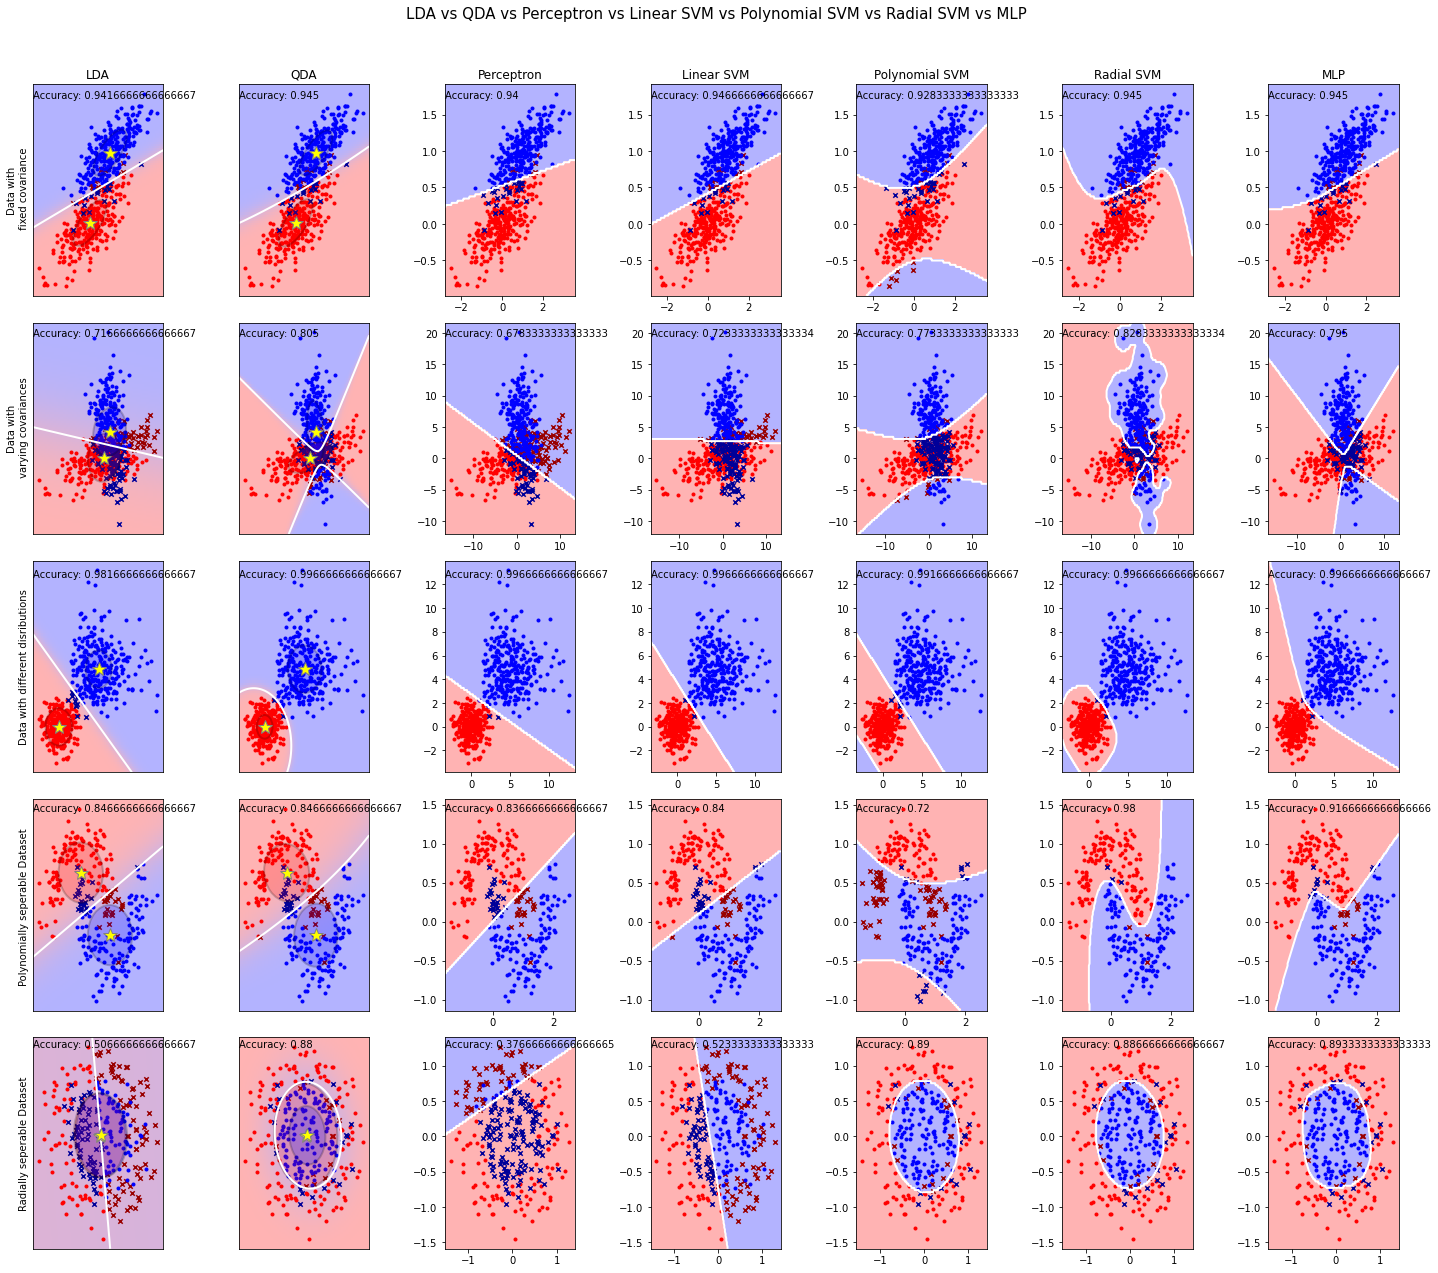

In [9]:
# general title and plot size
plt.figure(figsize=(20, 18), facecolor="white")
plt.suptitle(
    "LDA vs QDA vs Perceptron vs Linear SVM vs Polynomial SVM vs Radial SVM vs MLP",
    y=0.98,
    fontsize=15,
)

ClassifiersNum = 7
DatasetsNum = 5

# loop through both datasets, first with fixed covariance for both classes, and the second for different covariance matrix for both classes
for i, (X, y) in enumerate([dataset_fixed_cov(), dataset_cov(), dataset_different_distributions(), dataset_polynomial(), dataset_radial()]):
    # Linear Discriminant Analysis using SVD solver.
    lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
    # fit the prelabelled data to identify the line equation weights, then predict using the weights the calculated y values
    y_pred = lda.fit(X, y).predict(X)
    # call the plot_data for the LDA of the current dataset
    splot = plot_data(lda, X, y, y_pred, fig_index=ClassifiersNum * i + 1)
    plot_lda_cov(lda, splot)
    plt.axis("tight")

    # Quadratic Discriminant Analysis
    qda = QuadraticDiscriminantAnalysis(store_covariance=True)
    # fit the prelabelled data to identify the line equation weights, then predict using the weights the calculated y values
    y_pred = qda.fit(X, y).predict(X)
    # call the plot_data for the QDA of the current dataset
    splot = plot_data(qda, X, y, y_pred, fig_index=ClassifiersNum * i + 2)
    plot_qda_cov(qda, splot)
    plt.axis("tight")
    
    # Perceptron
    perceptron = Perceptron(tol=1e-3, random_state=0)
    Perceptron()
    perceptron.fit(X, y)
    # fit the prelabelled data to identify the line equation weights, then predict using the weights the calculated y values
    y_pred = perceptron.predict(X)
    #clf.score(X, y)
    # call the plot_data for the QDA of the current dataset
    splot = plot_data(perceptron, X, y, y_pred, fig_index=ClassifiersNum * i + 3, perceptron = True)
    #plot_qda_cov(qda, splot)
    plt.axis("tight")
    
    # SVM Linear Kernel
    svc_linear = SVC(kernel='linear', C=1.0)   # C = 1.0, SVM regularization parameter
    svc_linear.fit(X, y)
    # fit the prelabelled data to identify the line equation weights, then predict using the weights the calculated y values
    y_pred = svc_linear.predict(X)
    #clf.score(X, y)
    # call the plot_data for the QDA of the current dataset
    splot = plot_data(svc_linear, X, y, y_pred, fig_index=ClassifiersNum * i + 4, perceptron = True)
    #plot_qda_cov(qda, splot)
    plt.axis("tight")
    
    # SVM Polynomial Kernel
    poly_svc = SVC(kernel = 'poly', degree=2, C=1.0)
    poly_svc.fit(X, y)
    # fit the prelabelled data to identify the line equation weights, then predict using the weights the calculated y values
    y_pred = poly_svc.predict(X)
    #clf.score(X, y)
    # call the plot_data for the QDA of the current dataset
    splot = plot_data(poly_svc, X, y, y_pred, fig_index=ClassifiersNum * i + 5, perceptron = True)
    #plot_qda_cov(qda, splot)
    plt.axis("tight")
    
    # SVM Radial Kernel
    rbf_svc = SVC(kernel = 'rbf', random_state = 0, gamma=0.7, C=1.0)
    rbf_svc.fit(X, y)
    # fit the prelabelled data to identify the line equation weights, then predict using the weights the calculated y values
    y_pred = rbf_svc.predict(X)
    #clf.score(X, y)
    # call the plot_data for the QDA of the current dataset
    splot = plot_data(rbf_svc, X, y, y_pred, fig_index=ClassifiersNum * i + 6, perceptron = True)
    #plot_qda_cov(qda, splot)
    plt.axis("tight")
    
    # Multilayer perceptron
    mlp = MLPClassifier(random_state=1, max_iter=300)
    mlp.fit(X, y)
    # fit the prelabelled data to identify the line equation weights, then predict using the weights the calculated y values
    y_pred = mlp.predict(X)
    #clf.score(X, y)
    # call the plot_data for the QDA of the current dataset
    splot = plot_data(mlp, X, y, y_pred, fig_index=ClassifiersNum * i + 7, perceptron = True)
    #plot_qda_cov(qda, splot)
    plt.axis("tight")
    
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()